In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point, MultiPoint
from shapely import affinity
from scipy import spatial
import time
import math
import ezdxf

In [2]:
path="./Examples/Input/3DVESBUILDINGDXF/3DVESBUILDING_Reflected Ceiling Plan - LEVEL 01_02152022.dxf"
doc = ezdxf.readfile(path)
msp = doc.modelspace()

faces=[]
GridPoints = []
basePoints = []
i=0
j=0
names = []
spaces = []
for flag_ref in msp.query('HATCH'):
    name = flag_ref.dxf.pattern_name
    hatch_name =name.find('FP')
    hatch_layer=flag_ref.dxf.layer.find('CLNG')
    if hatch_name != -1 and hatch_layer != -1:
        patterns = flag_ref.pattern.lines
        paths = flag_ref.paths.default_paths()
        space = {"name":name,"FP_":[]}
        
        if len(patterns) == 2:
            for path in flag_ref.paths:
                face = {"face":[]}
                edges = path.edges
                plotface =[]
                for edge in edges:
                    point= []
                    b=edge.start
                    point.append(edge.start.x)
                    point.append(edge.start.y)
                    plotface.append(edge.start.x)
                    plotface.append(edge.start.y)
                    face["face"].append(point)

                space["FP_"].append(face)
        
            for pattern in patterns:
                
                angle = pattern.angle
                angle_dict = {"Angle":[]}
                angle_dict["Angle"].append(angle)
                space["FP_"].append(angle_dict)
            
                basePoint = {"BasePoint":[]}
                base_point_x = pattern.base_point.x
                base_point_y  = pattern.base_point.y
                base_point = [base_point_x,base_point_y]
                basePoint["BasePoint"].append(base_point)
                space["FP_"].append(basePoint)
        
        
                offset = {"Offset":[]}
                offset_x = pattern.offset.x
                offset_y = pattern.offset.y
                offset_point = [offset_x,offset_y]
                offset["Offset"].append(offset_point)
                space["FP_"].append(offset)
        
                point= []
                tr_point = {"TransltdPoint":[]}
                tr_point["TransltdPoint"].append([base_point_x+offset_x,base_point_y+offset_y])
                space["FP_"].append(tr_point)
            spaces.append(space)
            
        if len(patterns) != 2:
            for path in flag_ref.paths:
                face = {"face":[]}
                edges = path.edges
                plotface =[]
                for edge in edges:
                    point= []
                    b=edge.start
                    point.append(edge.start.x)
                    point.append(edge.start.y)
                    plotface.append(edge.start.x)
                    plotface.append(edge.start.y)
                    face["face"].append(point)

                space["FP_"].append(face)
        
            for pattern in patterns:
                
                angle_dict = {"Angle":[]}
                angle_dict["Angle"].append(None)
                space["FP_"].append(angle_dict)
            
                basePoint = {"BasePoint":[]}
                basePoint["BasePoint"].append(None)
                space["FP_"].append(basePoint)
        
        
                offset = {"Offset":[]}
                offset["Offset"].append(None)
                space["FP_"].append(offset)
        
                tr_point = {"TransltdPoint":[]}
                tr_point["TransltdPoint"].append([None])
                space["FP_"].append(tr_point)

In [3]:
def rotate(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

--- 300.6573178768158 seconds ---
--- 5.01095529794693 minutes ---


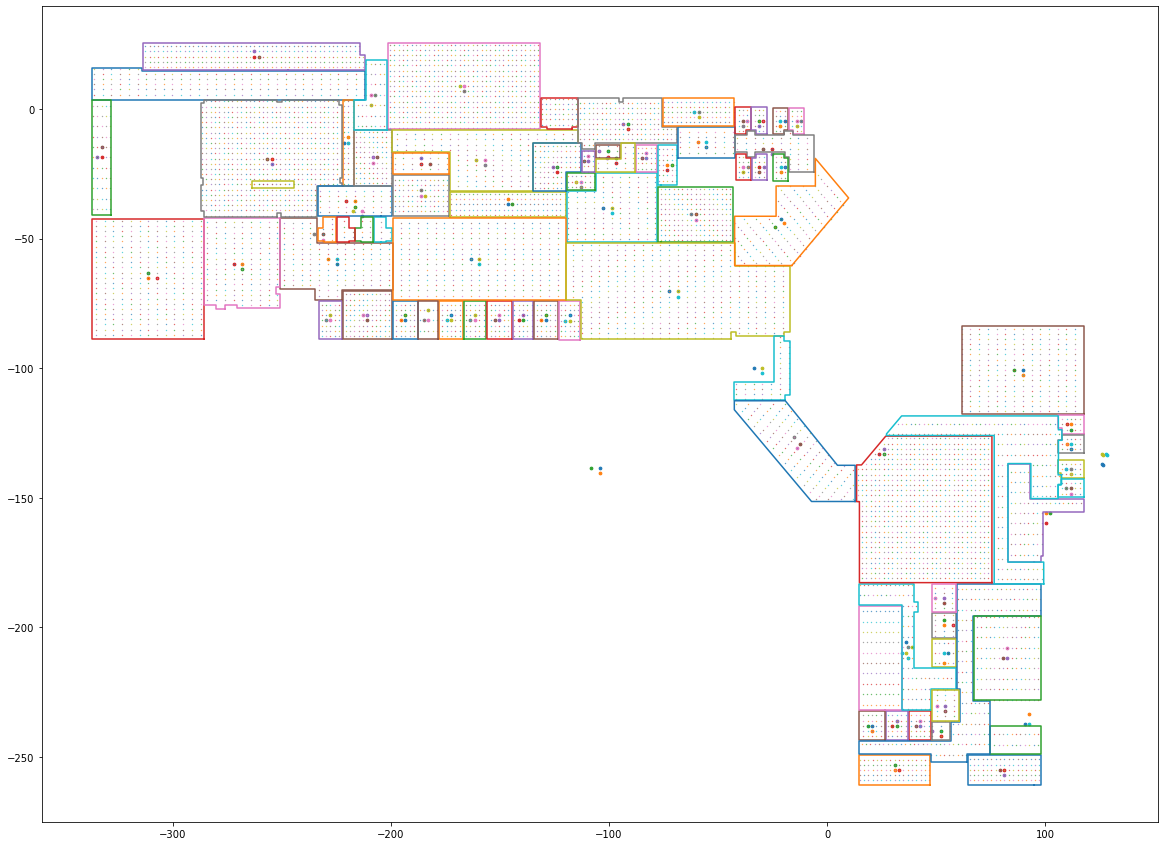

In [4]:
start_time = time.time()

jsonToMethod1 = spaces

plt.figure(figsize=(20,15))
infoCeilingOutput = []

for i in range(len(jsonToMethod1)):
    refPoint = []
    distance = []
    faces = []
    angles = []
    for k in range(len(jsonToMethod1[i]['FP_'])):
        tag = jsonToMethod1[i]['FP_'][k]
        for name in tag:
            if name == "face":
                listxy = jsonToMethod1[i]['FP_'][k]['face']
                x = []
                y = []
                for j in listxy:
                    x.append(j[0])
                    y.append(j[1])
                x.append(listxy[0][0])
                y.append(listxy[0][1])
                plt.plot(x,y)
                faces.append(Polygon(listxy))
            elif name == "BasePoint":
                if jsonToMethod1[i]['FP_'][k]['BasePoint'][0] not in refPoint:
                    refPoint.append(jsonToMethod1[i]['FP_'][k]['BasePoint'][0])
                    plt.scatter(jsonToMethod1[i]['FP_'][k]['BasePoint'][0][0],jsonToMethod1[i]['FP_'][k]['BasePoint'][0][1],marker='.',s=30)
            elif name == "TransltdPoint":
                if jsonToMethod1[i]['FP_'][k]['TransltdPoint'][0] not in refPoint:
                    refPoint.append(jsonToMethod1[i]['FP_'][k]['TransltdPoint'][0])
                    plt.scatter(jsonToMethod1[i]['FP_'][k]['TransltdPoint'][0][0],jsonToMethod1[i]['FP_'][k]['TransltdPoint'][0][1],marker='.',s=30)
            elif name == "Offset":
                distance.append(jsonToMethod1[i]['FP_'][k]['Offset'][0]) 
            elif name == "Angle":
                if(jsonToMethod1[i]['FP_'][k]['Angle'][0] % 90 != 0):
                    angles.append(jsonToMethod1[i]['FP_'][k]['Angle'][0])
        
    for d in range(len(distance)):
        for di in range(len(distance[d])):
            if(round(distance[d][di])!=0 and di == 0):
                distancex = abs(distance[d][di])
            elif(round(distance[d][di])!=0 and di == 1):
                distancey = abs(distance[d][di])
    if angles:
        distancey = np.abs(distance[0][0]/np.cos(math.radians(angles[0])))
        distancex = np.abs(distance[1][0]/np.cos(math.radians(angles[0])))
        
    for poliFace in faces:
        latmin, lonmin, latmax, lonmax = poliFace.bounds
        points = []
        plus = 500
        
        if poliFace.contains(MultiPoint(refPoint)):
            plus = 200
            
        for lat in np.arange(latmin-plus, latmax+plus, distancex):
            for lon in np.arange(lonmin-plus, lonmax+plus, distancey):
                points.append((round(lat,4), round(lon,4)))
                
        tree = spatial.KDTree(points)
        result = tree.query(refPoint[1])
        
        adjust = []
        for element in points:
            add = affinity.translate(Point(element), xoff=((refPoint[1][0])-(points[result[1]][0])), yoff=((refPoint[1][1])-(points[result[1]][1])), zoff=0.0)
            if angles:
                add = Point(rotate(refPoint[1], (add.x,add.y), math.radians(angles[0])))
            adjust.append(add)
        
        valid_points = []
        
        valid_points.extend([m for m in adjust if poliFace.contains(m)])
        
        pointsInCoords = []
        for l in range(len(valid_points)):
            plt.scatter(valid_points[l].x,valid_points[l].y,marker='.',s=0.4)
            pointsInCoords.append([valid_points[l].x,valid_points[l].y])
            
        infoCeiling = {'name':jsonToMethod1[i]['name'],'pointsGrid': pointsInCoords}
        infoCeilingOutput.append(infoCeiling)
        
#with open('./Examples/Output/FINAL/PARKER_L2.json', 'w') as file:
#    json.dump(infoCeilingOutput, file, indent=4)
        
totaltimeinseconds = (time.time() - start_time)
totaltimeinminutes = totaltimeinseconds/60

print("--- %s seconds ---" % totaltimeinseconds)
print("--- %s minutes ---" % totaltimeinminutes)